In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize

In [13]:
%config InlineBackend.figure_format = "retina"

In [14]:
port_path = "PreciosPortf.xlsx"
data = pd.read_excel(port_path, index_col=0)

rend = data.pct_change().dropna()

In [15]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights) * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

In [16]:
weights_sim = np.random.random((5000, 5))
weights_sim = weights_sim / weights_sim.sum(axis=1, keepdims=True)

rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim = np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

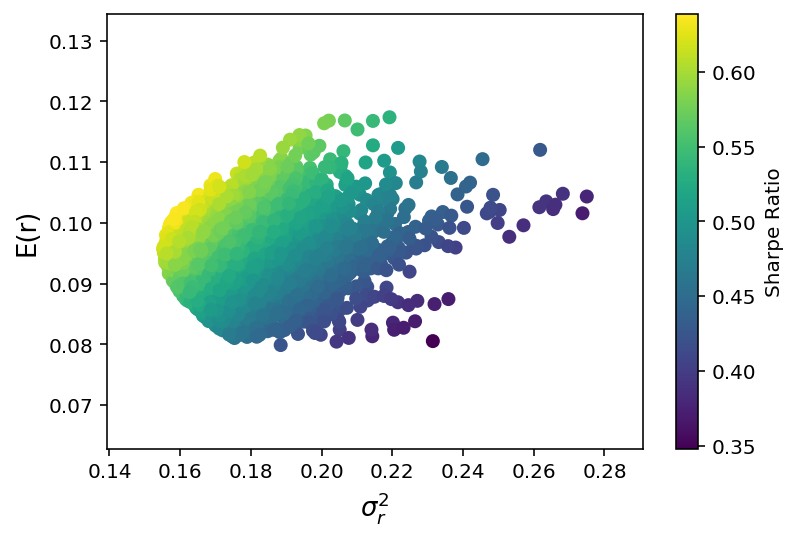

In [31]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13);

In [21]:
N, M = rend.shape
w0  = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() - 1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

#Función para definir restricción en la que los pesos 1 y 2 sumen 10%
def sum_weights_12(weights):
    return weights[0] + weights[1] - 0.1

constraints = [
    {"type": "eq", "fun": sum_weights}
]

port0 = minimize(port_vol, w0, constraints=constraints, args=rend)
wp0 = port0.x

In [22]:
rend_ports = rend.mean() * 252
r_min = port_rend(wp0, rend)
r_max = rend_ports.max()

rend_max = np.linspace(r_min, r_max)

In [23]:
pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

In [24]:
r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w, rend))
    v_opt.append(port_vol(w, rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

In [25]:
rf = 0.06

def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf) / port_vol(weights, rend)

constraints = [
    {"type": "eq", "fun": sum_weights}
]

f_sharpe = minimize(min_func_sharpe, w0, constraints=constraints)

In [26]:
w_sharpe = f_sharpe.x
e_sharpe = port_rend(w_sharpe, rend)
vol_sharpe = port_vol(w_sharpe, rend)

In [29]:
print("Cuál es el monto invertido: ", end="")
monto = float(input())

var_ind_di_95 = ((rend.var() ** 0.5) * w_sharpe * norm.ppf(0.95) * monto).sum()
var_port_di_95 = port_vol(w_sharpe, rend) * norm.ppf(0.95) * monto / (252 ** 0.5)
ef_dif_di_95 = var_ind_di_95 - var_port_di_95

var_ind_an_95 = var_ind_di_95 * (252 ** 0.5)
var_port_an_95 = var_port_di_95 * (252 ** 0.5)
ef_dif_an_95 = var_ind_an_95 - var_port_an_95

var_ind_di_99 = ((rend.var() ** 0.5) * w_sharpe * norm.ppf(0.99) * monto).sum()
var_port_di_99 = port_vol(w_sharpe, rend) * norm.ppf(0.99) * monto / (252 ** 0.5)
ef_dif_di_99 = var_ind_di_99 - var_port_di_99

var_ind_an_99 = var_ind_di_99 * (252 ** 0.5)
var_port_an_99 = var_port_di_99 * (252 ** 0.5)
ef_dif_an_99 = var_ind_an_99 - var_port_an_99

print(f"- VaR diario al 95% es de {var_ind_di_95:,.2f} para las acciones individuales; {var_port_di_95:,.2f} para el portafolio; {ef_dif_di_95:,.2f} diversificación")
print(f"- VaR anual al 95% es de {var_ind_an_95:,.2f} para las acciones individuales; {var_port_an_95:,.2f} para el portafolio; {ef_dif_an_95:,.2f}  diversificación")
print(f"- VaR diario al 99% es de {var_ind_di_99:,.2f} para las acciones individuales; {var_port_di_99:,.2f} para el portafolio; {ef_dif_di_99:,.2f}  diversificación")
print(f"- VaR anual al 99% es de {var_ind_an_99:,.2f} para las acciones individuales; {var_port_an_99:,.2f} para el portafolio; {ef_dif_an_99:,.2f} diversificación")

Cuál es el monto invertido: 200
- VaR diario al 95% es de 5.24 para las acciones individuales; 4.10 para el portafolio; 1.13 diversificación
- VaR anual al 95% es de 83.13 para las acciones individuales; 65.15 para el portafolio; 17.98  diversificación
- VaR diario al 99% es de 7.41 para las acciones individuales; 5.80 para el portafolio; 1.60  diversificación
- VaR anual al 99% es de 117.57 para las acciones individuales; 92.15 para el portafolio; 25.43 diversificación
